DAY 03 - Feb 27, 2017

# APIs & Sentiment analysis

In [1]:
import yaml
import praw

import nltk

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import matplotlib.pyplot as plt

/Users/csiu/software/anaconda/anaconda2-4.0.0/envs/kaggle/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = [15,4]
plt.style.use('ggplot')

## Connecting to Reddit using PRAW api wrapper

`pip install praw`

We begin with authentication (see https://praw.readthedocs.io/en/latest/getting_started/authentication.html)<br>using
`client_id` and `client_secrete` found at https://www.reddit.com/prefs/apps/.

In [4]:
# Load my secrets from external file
with open("_api-reddit.yaml", 'r') as stream:
        my_secret = yaml.load(stream)

client_id = my_secret['client_id']
client_secret = my_secret['client_secret']

We follow this tutorial: https://praw.readthedocs.io/en/latest/tutorials/comments.html

In [5]:
# Create instance of Reddit
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/USERNAME)',
                     client_id=client_id, client_secret=client_secret)

### Mining for Reddit comments

> Men of Reddit, what's the biggest "I'm a princess" red flag?
> -- thewhackcat

In [6]:
the_url = 'https://www.reddit.com/r/AskReddit/comments/5wkkwg/men_of_reddit_whats_the_biggest_im_a_princess_red/'

In [7]:
submission = reddit.submission(url=the_url)
submission

Submission(id='5wkkwg')

In [8]:
# RE: replace_more()
# replace or remove all the MoreComments object in the comment forest
# each replacement requires 1 network request & response may yield more MoreComments instances
# max limit = 32
submission.comments.replace_more(limit=0)

"""
# Search top level comments
for top_level_comment in submission.comments:
    print(top_level_comment.body)
"""

# List all comments + second, third, etc level ones (breadth first search)
data = []
for comment in submission.comments.list():
    data.append(comment.body)

## Sentiment analysis
We follow this tutorial: http://www.nltk.org/howto/sentiment.html to find out how the redditors feel feel

In [9]:
# Documents for training
n_instances = 5000  # subjectivity data set is size 5000
n_trainset = int(n_instances * 0.8)

subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

# Train on first 80; test on last 20
train_subj_docs = subj_docs[:n_trainset]
test_subj_docs = subj_docs[n_trainset:n_instances]
train_obj_docs = obj_docs[:n_trainset]
test_obj_docs = obj_docs[n_trainset:n_instances]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs

# Create instance of SentimentAnalyzer
sentim_analyzer = SentimentAnalyzer()

# Append _NEG suffix to words that appear in the scope between a negation and a punctuation mark
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

> A [SentimentAnalyzer](http://www.nltk.org/api/nltk.sentiment.html) is a tool to implement and facilitate Sentiment Analysis tasks using NLTK features and classifiers

The VADER sentiment analysis tools is by the following:

    Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014

In [10]:
# Use simple unigram word features
# word must appear with a minimum of 4 times to be considered as a feature
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)

# Enable feature extraction
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

# Apply all feature extractor functions to the documents
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)

In [11]:
# Train classifier
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

# Evaluate classifier on hold out test set
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.91
F-measure [obj]: 0.908256880733945
F-measure [subj]: 0.9116781157998036
Precision [obj]: 0.9261954261954262
Precision [subj]: 0.894990366088632
Recall [obj]: 0.891
Recall [subj]: 0.929


### Applying the classifier to our the Reddit comments

In [12]:
"""
# Consider each sentence in response as 1 item
sentences = data
"""

# Consider each sentence in response separately
sentences = []
for d in data:
    sentences.extend(tokenize.sent_tokenize(d))

In [13]:
sid = SentimentIntensityAnalyzer()

# compound = aggregate score of negative (neg), neutral (neu), and positive (pos)
d = []
for sentence in sentences:
    d.append(sid.polarity_scores(sentence))

In [14]:
df = pd.DataFrame(d)
print(df.shape)
df.head()

(1053, 4)


,compound,neg,neu,pos
0,-0.3182,0.199,0.664,0.137
1,0.0000,0.000,1.000,0.000
2,0.3412,0.000,0.714,0.286
3,0.4404,0.000,0.707,0.293
4,0.4939,0.000,0.714,0.286


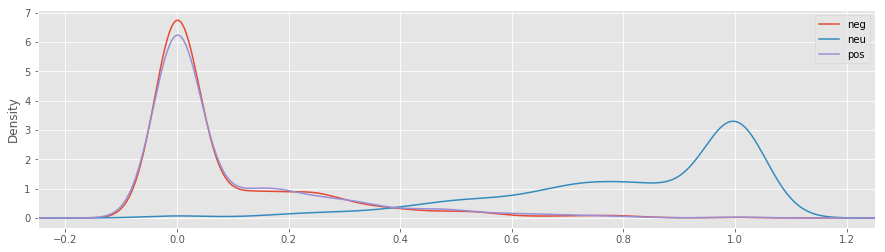

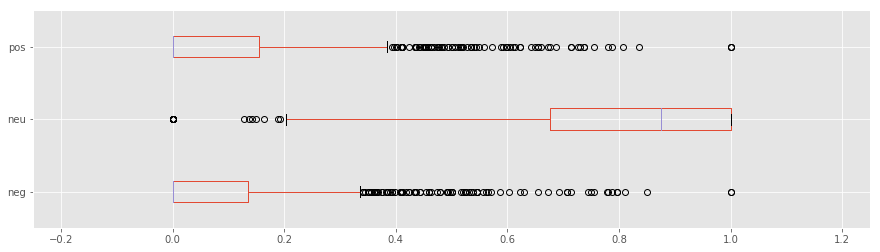

In [15]:
df.drop("compound", axis=1).plot.kde(xlim=[-.25, 1.25])
df.drop("compound", axis=1).plot.box(vert=False, xlim=[-.25, 1.25])

We find that most people are neutral.

### Most positive and most negative comments

In [16]:
n = 5

# Top N most negative & positive comments
index_neg = df.sort_values(by=['compound']).head(n).index.values
index_pos = df.sort_values(by=['compound']).tail(n).index.values[::-1] #reverse order

In [17]:
def print_sentence(db, index_ndarray):    
    for i,index in enumerate(index_ndarray.tolist()):
        print("#", i+1,'-'*70, sep="")
        print(db[index])
        print("")

In [18]:
print_sentence(sentences, index_neg)

#1----------------------------------------------------------------------
I was playing as the high chief of Novgorod today (starts as holomomor or something) and I had to kill that motherfucker who owns the only port at the start of the game and holy shit that guy survived more assassination attempts than I have ever seen.

#2----------------------------------------------------------------------
"You stupid lemon stealing whore"

#3----------------------------------------------------------------------
Knew a girl who sucked dick behind Macy's, was a total princess and got pissed off when everyone found out she was more trashy than her Facebook statuses had suggested

#4----------------------------------------------------------------------
Relationships get fucking adversarial and antagonistic so often and that's total cancer for a relationship.

#5----------------------------------------------------------------------
Finally just said, "Fuck it," and imprisoned his ass and executed him

In [19]:
print_sentence(sentences, index_pos)

#1----------------------------------------------------------------------
I still do have more male friends than female, but friends are friends, so who cares?

#2----------------------------------------------------------------------
She was fun, had a great sense of humor and she was absolutely gorgeous.

#3----------------------------------------------------------------------
"Father" is the person who provided half your DNA, "dad" is the person who lovingly raised you to the best of his ability.

#4----------------------------------------------------------------------
One of my best friends had a girlfriend once say she likes to have nicer things than other people, but doesn't want to work so he needs to have a good job.

#5----------------------------------------------------------------------
Turns out, she was an actual direct descendant and princess of Mowri royalty in hawai'i and meant she was a princess in that she always acted with grace, charm and dignity because she represent

In [27]:
# Save input to data file
data_file = "api-reddit_2017-02-27_" + submission.id + ".yaml"
with open(data_file, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)